### Data sources and parameters

In [7]:
DATASET_DIR = 'datasets/datasetA'
CSV_PATH = 'datasets/dataset_A.csv'

# Splitting ratio for the train/test split
# example: 0.8 -> 80% of the dataset will be used for training, 20% for testing
SPLIT_RATIO = 0.8

## Define the dataset class

In [8]:
# import Dataset class from pytorch
from torch.utils.data import Dataset
import pandas as pd
import os
import cv2
import torch

# define a class for the dataset
class CaptchaDataset_1(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    # return the length of the dataset
    def __len__(self):
        return len(self.annotations)
    
    # return the item at the index
    def __getitem__(self, index):
        if torch.is_tensor(index):
            index = index.tolist()
        # get the image name from the csv file
        img_path = os.path.join(self.root_dir, str(self.annotations.iloc[index, 0]) + '.png')
        # read the image using cv2
        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        # get the label from the csv file
        y_label = torch.tensor(int(self.annotations.iloc[index, 1]))
        # return the image and the label

        if self.transform:
            image = self.transform(image)

        return (image, y_label)

## Define and train the model

Here we define the model, we split the data into training and testing sets, and we train the model and test it on the testing set.

In [9]:
import torchvision.transforms as transforms
import torch
import torch.nn as nn

# Define the model
class ReteNeurale(nn.Module):
    def __init__(self):
        super(ReteNeurale, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 4)
        self.pool = nn.MaxPool2d(2, 2)
        self.Dropout = nn.Dropout(0.3)
        self.batchNorm1 = nn.BatchNorm2d(20)
        self.conv2 = nn.Conv2d(20, 32, 4, stride=2)
        self.batchNorm2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, 4, stride=2)
        self.batchNorm3 = nn.BatchNorm2d(64)
        self.fc1 = nn.Linear(1600, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 36)

    def forward(self, x):
        x = self.batchNorm1(nn.functional.relu(self.conv1(x)))
        x = self.batchNorm2(nn.functional.relu(self.conv2(x)))
        x = self.pool(self.batchNorm3(nn.functional.relu(self.conv3(x))))
        x = x.view(-1, 1600)
        x = nn.functional.relu(self.fc1(x))
        #x = self.Dropout(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x

# Load the data
dataset = CaptchaDataset_1(csv_file=CSV_PATH, root_dir=DATASET_DIR, transform=transforms.ToTensor())

# Obtain images count in the dataset
dataset_size = len(dataset)

# Split the dataset into train and test
train_set_size = int(dataset_size * SPLIT_RATIO)
test_set_size = dataset_size - train_set_size

train_set, test_set = torch.utils.data.random_split(dataset, [train_set_size, test_set_size])

train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=32, shuffle=True)

# Create the model
model = ReteNeurale().to("cuda")

# Define the hyperparameters
learning_rate = 0.001
num_epochs = 30

# Define the loss function and the optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

# Train the model
n_total_steps = len(train_loader)

accValues = []
train_losses = []

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to("cuda")
        labels = labels.to("cuda")

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

        if (i+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')


                # Test the model
    with torch.no_grad():
        n_correct = 0
        n_samples = 0
        for images, labels in test_loader:
            images = images.to("cuda")
            labels = labels.to("cuda")
            outputs = model(images)
            # max returns (value ,index)
            _, predicted = torch.max(outputs, 1)
            n_samples += labels.size(0)
            n_correct += (predicted == labels).sum().item()
        
        acc = 100.0 * n_correct / n_samples
        print(n_correct, n_samples)
        print(f'Accuracy of the network: {acc} %')

print('Finished Training')

# Test the model
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for images, labels in test_loader:
        images = images.to("cuda")
        labels = labels.to("cuda")
        outputs = model(images)
        # max returns (value ,index)
        _, predicted = torch.max(outputs, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()
    
    acc = 100.0 * n_correct / n_samples
    print(n_correct, n_samples)
    print(f'Accuracy of the network: {acc} %')

Epoch [1/30], Step [100/268], Loss: 0.6827
Epoch [1/30], Step [200/268], Loss: 0.6065
1701 2140
Accuracy of the network: 79.48598130841121 %
Epoch [2/30], Step [100/268], Loss: 0.6035
Epoch [2/30], Step [200/268], Loss: 0.1332
1819 2140
Accuracy of the network: 85.0 %
Epoch [3/30], Step [100/268], Loss: 0.1404
Epoch [3/30], Step [200/268], Loss: 0.3318
1809 2140
Accuracy of the network: 84.53271028037383 %
Epoch [4/30], Step [100/268], Loss: 0.2245
Epoch [4/30], Step [200/268], Loss: 0.1688
1844 2140
Accuracy of the network: 86.16822429906541 %
Epoch [5/30], Step [100/268], Loss: 0.0515
Epoch [5/30], Step [200/268], Loss: 0.2632
1841 2140
Accuracy of the network: 86.02803738317758 %
Epoch [6/30], Step [100/268], Loss: 0.0192
Epoch [6/30], Step [200/268], Loss: 0.1329
1830 2140
Accuracy of the network: 85.51401869158879 %
Epoch [7/30], Step [100/268], Loss: 0.0248
Epoch [7/30], Step [200/268], Loss: 0.0088
1830 2140
Accuracy of the network: 85.51401869158879 %
Epoch [8/30], Step [100/26

## Training loss graph

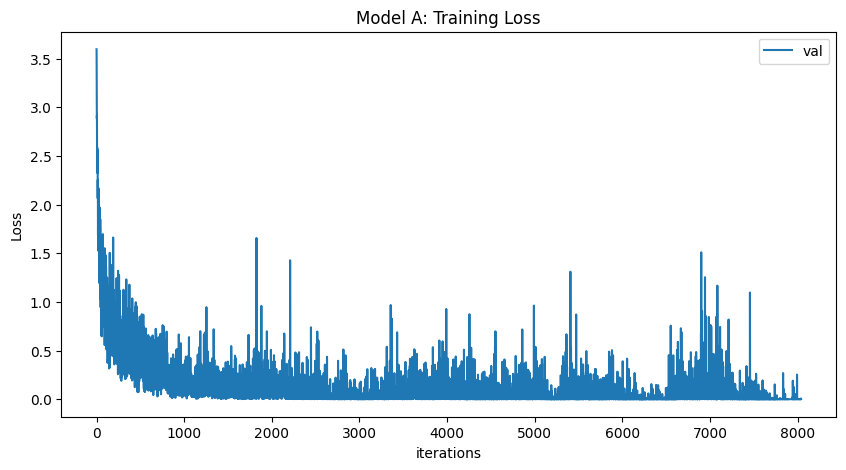

In [10]:
import matplotlib.pyplot as plt

val_losses = []

plt.figure(figsize=(10,5))
plt.title("Model A: Training Loss")
plt.plot(train_losses,label="val")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Store the model

Here we store the model in `models/model_A.pt`, so it can be used for predicting characters.

In [11]:
if not os.path.exists("models/"):
    os.makedirs("models/")

model_scripted = torch.jit.script(model)
model_scripted.save("models/model_A.pt")